# Medical project

## Historical data

In [1]:
import numpy as np
import pandas as pd

X = pd.read_csv('../../data/medical/historical_X.dat', header=None, sep=" ")
A = pd.read_csv('../../data/medical/historical_A.dat', header=None, sep=" ")
Y = pd.read_csv('../../data/medical/historical_Y.dat', header=None, sep=" ")
X = X.rename(index=str, columns={0: 'gender', 1: 'smoker'})
X = X.rename(index=str, columns={i: 'gene'+str(i-1) for i in range(2,128)})
X_old = X.copy()
X.insert(0, 'symptoms', X[128] + X[129]*2)
X = X.drop(labels=[128, 129], axis=1)
A = A.rename(index=str, columns={0: 'action'})
Y = Y.rename(index=str, columns={0: 'outcome'})

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set()

### Discovering structure in the data

#### a)

In [111]:
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from scipy.stats import sem

In [4]:
n_cluster = np.arange(1,15,2)
scores_mean = np.zeros(len(n_cluster))
scores_sem = np.zeros(len(n_cluster))
for i, n in enumerate(n_cluster):
    scores = np.zeros(10)
    for j, (train, test) in enumerate(KFold(n_splits=10).split(X_old)):
        kmeans = KMeans(n_clusters=n).fit(X.iloc[train])
        scores[j] = kmeans.score(X.iloc[test])
    
    scores_mean[i] = scores.mean()
    scores_sem[i] = sem(scores)

<BarContainer object of 7 artists>

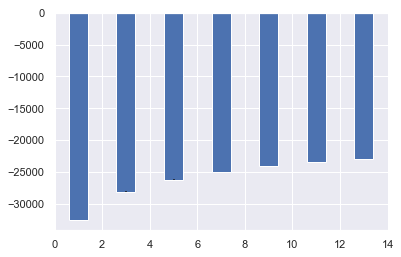

In [5]:
plt.bar(x=n_cluster, height=scores_mean, yerr=scores_sem)

OK, we have to do something different, because KMeans will just look better and better the more clusters we use (I also tried np.arange(1,150,20)).

From [SKlearn](http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) documentation it looks like Hierarchical Clustering might be a good way to go, but we need to define a metric for similarity. In [A Survey of Binary Similarity and Distance Measures by Choi et al, 2010](http://www.iiisci.org/Journal/CV$/sci/pdfs/GS315JG.pdf) there are 76 potential similarity/distance measures listed. It's difficult to make a very informed decision as to which is the best in our scenario, but we should be able to find one so that we don't have to invent one on our own. It looks as though our features are symmetric (that both 0 and 1 encode some state) and not asymetric (that 0 encodes absence of something and 1 presence) as the mean sum of the genetic features is 64.6 from a total of 126 and the gender is obvious. The exceptions are smoker and the two symptons features, although smoker could also be considered symmetric.

For the symmetric features match ratio (Sokal&Michener) seems as good as any, whereas for the asymetric Faith-similarity where negative matches are downplayed seems like a good idea. I don't suppose there is anything wrong in combining them, though given how few asymetric features we have we could just as well have used S&M on all. Given the fact that scipy.spatial.distance has a metric sokalmichener that seems like the best way to go.

Now, with the AgglomerativeClustering in SKLearn we don't have a score or a predict method. It seems we can only fit, or fit and predict on the same dataset. There is, however, some measures of cluster fit that can be used, such as silhouette score. I was also considering something like doing CV and predicting every time on the training set, then storing the 9 labels we get from this and creating some measure of how similar the 9 labels created when fitting the clustering on different data, but one big problem with this is how to judge which number of clusters is best. Obviously we'll get perfect score on this if we use 1 cluster. The more clusters the bigger the chance of having differences in the classification. Balancing that well would be hard.

I also came across [Powered Outer Probabilistic Clustering, Taraba, 2017](http://www.iaeng.org/publication/WCECS2017/WCECS2017_pp394-398.pdf) which looks interesting and well suited to our binary data, but it doesn't seem to have caught on, and it would have to be implemented from scratch. To get any kind of efficiency that would probably need to be done in C using Cython or something, and even though C#-code is provided it was an unsurmountable obstacle for this project.

In [6]:
X.iloc[:].iloc[3:].sum(axis=1).mean()

64.58447534260279

In [7]:
from scipy.spatial.distance import sokalmichener
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances

In [140]:
distances = pairwise_distances(X_old, metric=sokalmichener)

In [10]:
distances.shape

(10000, 10000)

In [39]:
n_cluster = np.arange(1,9)
scores = np.zeros(len(n_cluster))
clusters = np.zeros([len(X_old), len(n_cluster)], dtype=np.int)
for i, n in enumerate(n_cluster):
    clusterer = AgglomerativeClustering(n_clusters=n, affinity='precomputed', 
                                        linkage="average")
    clusters[:,i] = clusterer.fit_predict(distances)

In [35]:
for i in range(1, len(n_cluster)):
    scores[i] = silhouette_score(distances, clusters[:,i], metric='precomputed')

<BarContainer object of 7 artists>

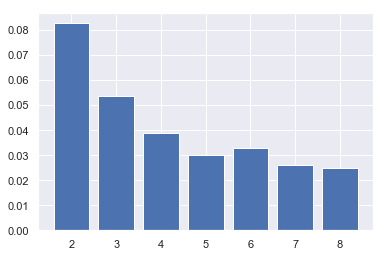

In [36]:
plt.bar(n_cluster[1:], scores[1:])

The silhouette score is not defined for a single cluster, so we can only judge multiple clusters. We see from the scores however, that no matter the number of clusters there is a significant overlap between the clusters. 2 clusters seem best, but at the same time they have so significant overlap that we might as well have concluded that they in are a single cluster.

We can always try instead of silhouette to calculate the probabilities of seeing the data given their labelling and the number of clusters, then compare the total likelihood for each cluster-size.

To do that we'll set 
$$x_{ij} \sim Bernoulli(p_{jk})$$
$$p_{jk} \sim Beta(\alpha_{jk}, \beta_{jk})$$
Then, for each feature and label we find $\alpha$ and $\beta$, and then for each datapoint and it's label we calculate $\sum_{j=1}^d \log((x_{ij}==1)p_{jk}+(x_{ij}==0)(1-p_{ij})$. Here $(x_{ij}==1)p_{jk}+(x_{ij}==0)(1-p_{ij})$ can be simplified as $x_{ij}p_{jk}+(1-x_{ij})(1-p_{jk}) = 2x_{ij}p_{jk}-x_{ij}-p_{jk}+1$

In [65]:
loglik = np.zeros_like(n_cluster, dtype=np.float64)
d = X_old.shape[1]
for k, n in enumerate(n_cluster):
    # For each feature and label find alpha and beta
    alpha = np.ones([d, n])
    beta = np.ones([d, n])
    for i, x_i in enumerate(X_old.values):
        for j, x_ij in enumerate(x_i):
            alpha[j, clusters[i,k]] += x_ij
            beta[j, clusters[i,k]] += 1 - x_ij
    # For each datapoint, find log lik
    for i, x_i in enumerate(X_old.values):
        for j, x_ij in enumerate(x_i):
            a = alpha[j, clusters[i,k]]
            b = beta[j, clusters[i,k]]
            p_jk = a / (a + b)
            loglik[k] += np.log(x_ij*p_jk + (1-x_ij)*(1-p_jk))

0 0.501499700059988 0.498500299940012
0 0.5068890500362582 0.49311094996374183
0 0.5068890500362582 0.49311094996374183
0 0.50199203187251 0.49800796812749004
0 0.50199203187251 0.49800796812749004
0 0.50199203187251 0.49800796812749004
0 0.50199203187251 0.49800796812749004
0 0.4987506246876562 0.5012493753123438


<BarContainer object of 8 artists>

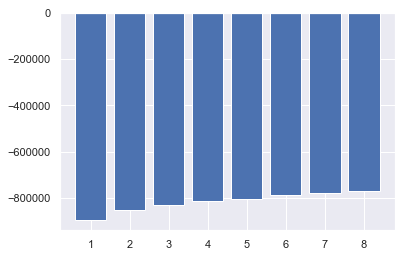

In [66]:
plt.bar(n_cluster, loglik)

So here again we see, the more clusters the more likely the data, but this is unsurprising. If we try adjusting it with $BIC = log(N)*p - 2*loglik$ where p is numbers of fitted parameters (or really degrees of freedom) we get

In [78]:
BIC = np.zeros_like(loglik)
for i, n in enumerate(n_cluster):
    BIC[i] = np.log(X_old.shape[0])*d*2*n - 2*loglik[i]

<BarContainer object of 8 artists>

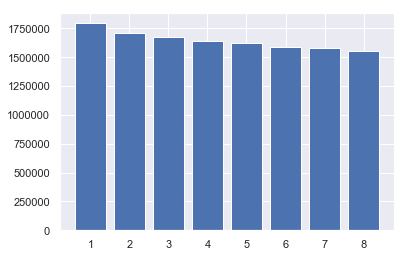

In [79]:
plt.bar(n_cluster, BIC)

But here we see, quite unsurprisingly, that the likelihood completely dominates since the log-likelihood roughly is $log(0.5)*d*N$ making the BIC roughly $log(N)*d*clusters*2 - 2*log(0.5)*d*N = 2d(N*log(2) + log(N)*clusters)$ and in this expression $N$ completely dominates $log(N)$, so how much we can reduce the 2 in the $log(2)$-term is far more important than how many clusters we use.

So in conclusion, based on this it seems very difficult to conclude with any number of clusters. The perhaps best answer is that the silhouette score for the best number of clusters, 2, is so close to 0 that it's hard to make any meaningful clusters at all. Perhaps, after we have done feature selection in b) we can try again with the more important features and see if we get any meaningful clusters, because now we just have a lot of random data apparently. Even though the BIC analysis suggests more clusters the BIC scores for multiple clusters are very high, suggesting that the clusters are very undefined.

#### b)

First lets try a l1-penalization on Logistic Regression to see if it can remove some features for us, trying to see what features can be used to predict the symptoms.

In [83]:
from sklearn.linear_model import LogisticRegression

In [100]:
Xs = X.drop(labels=['symptoms'], axis=1)
ys = X['symptoms']
clf = LogisticRegression(penalty='l1', C=0.1)
fit = clf.fit(Xs, ys)

In [89]:
1*(fit.coef_[:,:]>np.zeros(fit.coef_.shape[1])).sum(axis=1)

array([41, 17,  3,  5])

So this gives us from 3 to 41 important features, depending on the symptom class.

In [91]:
1*(fit.coef_[:,:]>np.zeros(fit.coef_.shape[1])).sum(axis=0)

array([0, 2, 0, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0])

But none of the same features look important across all symptom classes. Perhaps with weaker regularization

In [92]:
clf = LogisticRegression(penalty='l1', C=0.2)
fit = clf.fit(Xs, ys)
1*(fit.coef_[:,:]>np.zeros(fit.coef_.shape[1])).sum(axis=0)

array([1, 2, 1, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1,
       0, 1, 2, 1, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 2, 1, 1, 0, 1,
       1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 2, 2, 0, 1, 2, 1, 1, 1])

Nope, we just got a lot more features that appear significant in one class, but still none that seem so in more than 2.

Let's try something else. RandomForestClassifier and ExtraTreesClassifier come with a nice feature_importance measure, we can try one of those. According to [this](https://stackoverflow.com/questions/22409855/randomforestclassifier-vs-extratreesclassifier-in-scikit-learn) and [this](https://stats.stackexchange.com/questions/175523/difference-between-random-forest-and-extremely-randomized-trees) it doesn't seem to make a very big difference necessarily, and we could try both, but ExtraTrees seems according to this to possible deal somewhat better with high dimensions and high noise, which is what we have.

In [239]:
from sklearn.ensemble import ExtraTreesClassifier

In [241]:
# Random Forest classifiers don't overfit, so we might as well build a big forest
clf = ExtraTreesClassifier(n_estimators=1000)
clf.fit(Xs, ys)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [115]:
deviations = sem([tree.feature_importances_ for tree in clf.estimators_], axis=0)
sorted_feature_ixs = np.argsort(clf.feature_importances_)[::-1]

<BarContainer object of 128 artists>

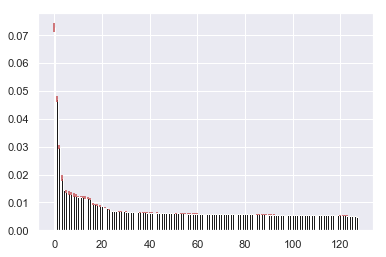

In [116]:
plt.bar(range(Xs.shape[1]), clf.feature_importances_[sorted_feature_ixs],
       color="k", yerr=deviations[sorted_feature_ixs], ecolor='r')

So we see that there are only very few of the features that seem to have any relevance, so let's try to cut it down to get a more informative plot.

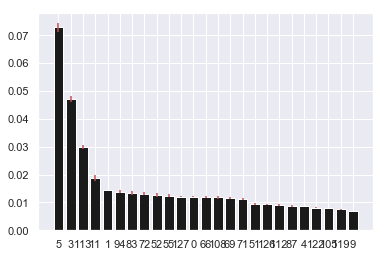

In [119]:
to_show = 25
plt.bar(range(to_show), (clf.feature_importances_[sorted_feature_ixs])[:to_show],
       color="k", yerr=(deviations[sorted_feature_ixs])[:to_show], ecolor='r')
plt.xticks(range(to_show), sorted_feature_ixs[:to_show])
plt.show()

It's always difficult to know where to make this cut, but from the looks of this, 4 seems like a good number. From 4-25 there seems to be a fairly general decline with a small step at 16, and after 25 it looks (from the first plot) quite flat. In any case, 5 is not all that much higher than the lowest, so I'll cut at 4.

In [125]:
X_cut = X.iloc[:,sorted_feature_ixs[:4]].copy()
X_cut[:5]

,gene3,gene1,gene111,gene9
0,1,0,1,0
1,0,0,0,1
2,0,1,1,1
3,0,1,0,0
4,0,0,0,1


Perhaps now we can try again to cluster our data with this reduced dataset, including in it also the symptoms that we used to select features

In [131]:
X_new = pd.concat([X_cut, X_old.iloc[:,-2:]], axis=1)
X_new[:5]

,gene3,gene1,gene111,gene9,128,129
0,1,0,1,0,1,0
1,0,0,0,1,0,0
2,0,1,1,1,0,0
3,0,1,0,0,0,0
4,0,0,0,1,1,0


In [139]:
distances2 = pairwise_distances(X_new, metric=sokalmichener)

<BarContainer object of 7 artists>

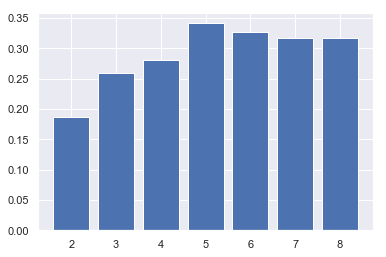

In [153]:
n_cluster = np.arange(1,9)
scores = np.zeros(len(n_cluster))
clusters = np.zeros([len(X_new), len(n_cluster)], dtype=np.int)
for i, n in enumerate(n_cluster):
    clusterer = AgglomerativeClustering(n_clusters=n, affinity='precomputed', 
                                        linkage="average")
    clusters[:,i] = clusterer.fit_predict(distances2)
for i in range(1, len(n_cluster)):
    scores[i] = silhouette_score(distances2, clusters[:,i], metric='precomputed')
plt.bar(n_cluster[1:], scores[1:])

<BarContainer object of 8 artists>

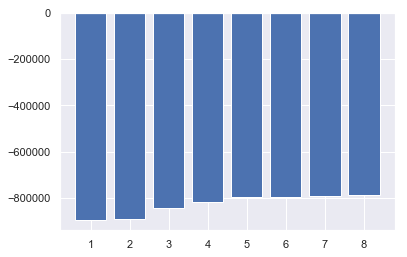

In [154]:
loglik = np.zeros_like(n_cluster, dtype=np.float64)
d = X_old.shape[1]
for k, n in enumerate(n_cluster):
    # For each feature and label find alpha and beta
    alpha = np.ones([d, n])
    beta = np.ones([d, n])
    for i, x_i in enumerate(X_old.values):
        for j, x_ij in enumerate(x_i):
            alpha[j, clusters[i,k]] += x_ij
            beta[j, clusters[i,k]] += 1 - x_ij
    # For each datapoint, find log lik
    for i, x_i in enumerate(X_old.values):
        for j, x_ij in enumerate(x_i):
            a = alpha[j, clusters[i,k]]
            b = beta[j, clusters[i,k]]
            p_jk = a / (a + b)
            loglik[k] += np.log(x_ij*p_jk + (1-x_ij)*(1-p_jk))
plt.bar(n_cluster, loglik)

<BarContainer object of 8 artists>

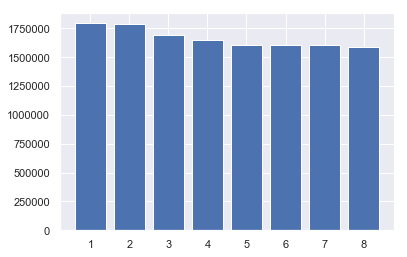

In [155]:
BIC = np.zeros_like(loglik)
for i, n in enumerate(n_cluster):
    BIC[i] = np.log(X_old.shape[0])*d*2*n - 2*loglik[i]
plt.bar(n_cluster, BIC)

In [156]:
BIC

array([1794487.73574171, 1791996.74974792, 1691592.54220145,
       1646287.29612007, 1607241.85728178, 1605633.77390828,
       1605268.40183749, 1591578.42879986])

Now the silhouette score gives us 5 fairly well defined clusters and the BIC score seems to even out at around 5 clusters, so with these 6 features we found to be most important it seems we could group our data into 5 clusters.

In [158]:
n_cluster = 5

In [163]:
C = clusters[:,(n_cluster-1)]
from collections import Counter
Counter(C)

Counter({1: 2192, 3: 2355, 2: 2563, 4: 2586, 0: 304})

### Measuring the effect of actions

Let's see first how the treatments are responded to

In [173]:
# Make a 2x2 matrix with rows being A(action) and columns being Y(effect)
responses = np.zeros([2,2])
for a, y in zip(A.values, Y.values):
    responses[a,y] += 1
responses/responses.sum(axis=1).reshape(2,1)

array([[0.99104129, 0.00895871],
       [0.41166232, 0.58833768]])

So we see that of people people receivng treatment 1, there is a slight majority observing effect 1, while among those receiving treatment 0 there is a vast majority observing effect 0. If we assume, and I think this is supported by the data, that action 1 is the supposedly effective treatment and effect 1 is healing then the placebo has virtually no effect, while the treatment has a fairly good effect.

Now let's try to group them for each cluster we discovered

In [189]:
np.set_printoptions(suppress=True)

In [190]:
response_matrix = np.zeros([n_cluster,2,2])
for i in range(len(A)):
    response_matrix[C[i],A.values[i],Y.values[i]] += 1
np.round(response_matrix,decimals=0)

array([[[  79.,    1.],
        [ 116.,  108.]],

       [[1666.,   13.],
        [ 137.,  376.]],

       [[2137.,    1.],
        [ 193.,  232.]],

       [[1835.,    2.],
        [ 325.,  193.]],

       [[1916.,   52.],
        [ 175.,  443.]]])

In [184]:
np.round(response_matrix/response_matrix.sum(axis=2).reshape(n_clusters,2,1),decimals=2)

array([[[0.99, 0.01],
        [0.52, 0.48]],

       [[0.99, 0.01],
        [0.27, 0.73]],

       [[1.  , 0.  ],
        [0.45, 0.55]],

       [[1.  , 0.  ],
        [0.63, 0.37]],

       [[0.97, 0.03],
        [0.28, 0.72]]])

So here we see that practically everyone who heals with placebo are in cluster 5, with some in cluster 2. Given how few they are that could just be random, but it is conspicous. What is more interesting is that there seems to be considerably higher healing rates in the same two clusters with medication as well.

There is no cluster of people for whom healing is better under placebo than the active drug, so from what we see here there is no reason to withold treatment from anyone. The exception to this is if the treatment is in scarce supply or is so expensive that we can't give it to anyone. In that case it seems best spent on clusters 2 and 5, and least well spent on cluster 4, but that also would depend on what it means to be healed. If the affliction in itself is not problematic, but only the sypmtoms are, then perhaps it's not worthwhile subjecting any asymptomatic people to treatment, and if cluster 4 has a significantly higher proportion of symptomatic people then perhaps that would be where we should allocate a scarce treatment even with poorer healing rates.

Another option is to see if we can pinpoint other features than cluster that can tell us something about healing.  
  
We don't know how people were selected to receive placebo or supposedly effective treatment, but given that one of the treatments is a placebo it seems natural to assume that the patients were split into the two groups randomly. Thus there is probably no true correlation between A and any features in X beyond what is there by chance. What we can do, of course, is to have a look at possible correlation between features in X and Y. To get as little noise as possible it's probably best to condition on A, but since there are hardly any healed with action 0 any result from that set will be very variable. For action a=1, however, we have plenty of people with both outcomes to get some potentialy sensible results. We can try again with both the Logistic Regression and the Random Forest classifiers to try to find important features.

In [219]:
X_A1 = X[A['action']==1].copy()
Y_A1 = Y[A['action']==1].copy()

In [218]:
X_A1.shape

(2298, 130)

In [230]:
clf = LogisticRegression(penalty='l1', C=0.01)
fit = clf.fit(X_A1, Y_A1.values.ravel())

In [222]:
from sklearn.feature_selection import SelectFromModel

In [231]:
model = SelectFromModel(fit, prefit=True)
fit.coef_[0,model.get_support()]

array([-0.54060995,  0.06628861,  0.18039801,  0.00594863,  0.08405915,
       -0.07683724, -0.2622275 ,  0.27531287,  0.90642858])

In [238]:
X_A1.columns.values[[model.get_support()]]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array(['gene6', 'gene22', 'gene43', 'gene47', 'gene49', 'gene57',
       'gene83', 'gene100', 'gene101'], dtype=object)

So we get a set of 9 genes after quite heavy regularization, but still they might just be randomly correlated with Y. Lets see what our forests do.

In [242]:
from sklearn.ensemble import RandomForestClassifier

In [244]:
clf1 = ExtraTreesClassifier(n_estimators=1000)
clf1.fit(X_A1, Y_A1.values.ravel())
deviations1 = sem([tree.feature_importances_ for tree in clf1.estimators_], axis=0)
sorted_feature_ixs1 = np.argsort(clf1.feature_importances_)[::-1]

In [246]:
clf2 = RandomForestClassifier(n_estimators=1000)
clf2.fit(X_A1, Y_A1.values.ravel())
deviations2 = sem([tree.feature_importances_ for tree in clf2.estimators_], axis=0)
sorted_feature_ixs2 = np.argsort(clf2.feature_importances_)[::-1]

In [245]:
to_show = 25

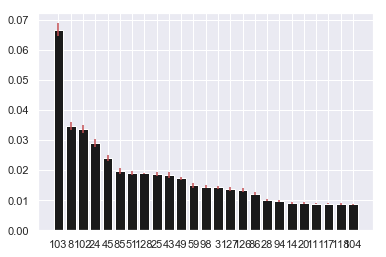

In [247]:
plt.bar(range(to_show), (clf1.feature_importances_[sorted_feature_ixs1])[:to_show],
       color="k", yerr=(deviations1[sorted_feature_ixs1])[:to_show], ecolor='r')
plt.xticks(range(to_show), sorted_feature_ixs1[:to_show])
plt.show()

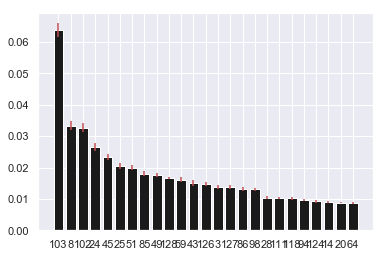

In [248]:
plt.bar(range(to_show), (clf2.feature_importances_[sorted_feature_ixs2])[:to_show],
       color="k", yerr=(deviations2[sorted_feature_ixs2])[:to_show], ecolor='r')
plt.xticks(range(to_show), sorted_feature_ixs2[:to_show])
plt.show()

Well, in the first there looks to be three natural cutoffs: 5, 10 or 17 features. In the second the cuts are less clear, but 5 and 17 look sensible there too, for a cut between it would just have to be a choice.

In [251]:
print(X_A1.columns.values[sorted_feature_ixs1[:5]])
print(X_A1.columns.values[sorted_feature_ixs2[:5]])
print(X_A1.columns.values[sorted_feature_ixs1[:10]])
print(X_A1.columns.values[sorted_feature_ixs2[:10]])
print(X_A1.columns.values[sorted_feature_ixs1[:17]])
print(X_A1.columns.values[sorted_feature_ixs2[:17]])

['gene101' 'gene6' 'gene100' 'gene22' 'gene43']
['gene101' 'gene6' 'gene100' 'gene22' 'gene43']
['gene101' 'gene6' 'gene100' 'gene22' 'gene43' 'gene83' 'gene49' 'gene126'
 'gene23' 'gene41']
['gene101' 'gene6' 'gene100' 'gene22' 'gene43' 'gene23' 'gene49' 'gene83'
 'gene47' 'gene126']
['gene101' 'gene6' 'gene100' 'gene22' 'gene43' 'gene83' 'gene49' 'gene126'
 'gene23' 'gene41' 'gene47' 'gene57' 'gene96' 'gene1' 'gene125' 'gene124'
 'gene84']
['gene101' 'gene6' 'gene100' 'gene22' 'gene43' 'gene23' 'gene49' 'gene83'
 'gene47' 'gene126' 'gene57' 'gene41' 'gene124' 'gene1' 'gene125' 'gene84'
 'gene96']


Interestingly, but perhaps not so surprisingly, after seeing the above two plots, the 5 most siginificant features are identical for both methods and in the 17 most significant they are identical, but 6-17 are ordered differently. For the 10 most significant there is one missing in each, but they then appear as 11 and 12.  
  
  We also see that only 1, gene1, of the 17 are in the list gene1, gene3, gene9 and gene111 that we clustered on and that were important for predicting symptoms. This is perhaps not surpring given that the symptoms seem irrelevant to predicting healing.  
  
  We also see that the list of 9 features we got from the LogisticRegression('gene6', 'gene22', 'gene43', 'gene47', 'gene49', 'gene57', 'gene83', 'gene100', 'gene101'), are also all in the top 11-12 on the trees as well.

Now of course, there is a chance that there is randomness involved in correlating these features with the healing rates, but how to test that? There isn't really a good way to determine whether these correlations are due to chance or some causal effect. We can try a couple of things to check the correlation, of course. We can cluster based on these features instead of the 6 we used in a) and recreate the matrices from above, and we can resample our dataset a few times and see which features turn up in the top 5 how many times.

In [303]:
from sklearn.utils import resample

In [253]:
B = 100
clf = ExtraTreesClassifier(n_estimators=1000)
top5 = np.zeros(len(X_A1.columns.values))
for b in range(B):
    X_S, y_S = resample(X_A1, Y_A1, n_samples=2000)
    clf.fit(X_S, y_S.values.ravel())
    top5[(np.argsort(clf.feature_importances_)[::-1])[:5]] += 1
top5 = {X_A1.columns.values[i]: v for i, v in enumerate(top5)}

In [258]:
sorted(top5.items(), key=lambda val: val[1])[-6:]

[('gene49', 24.0),
 ('gene43', 47.0),
 ('gene22', 94.0),
 ('gene100', 95.0),
 ('gene6', 96.0),
 ('gene101', 100.0)]

So we see that our list of 5 contains 4 features that appear in almost every top 5 ranking, while our original number 5 only is top 5 in about half. If we go forward with the 4 that are typically top 5 we get

In [269]:
X_sub = X[['gene101', 'gene6', 'gene100', 'gene22']].copy()
distances3 = pairwise_distances(X_sub, metric=sokalmichener)

<BarContainer object of 7 artists>

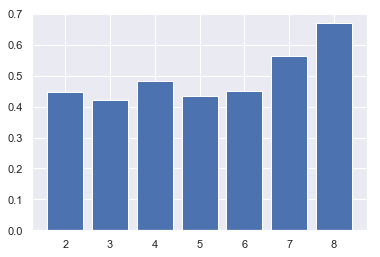

In [270]:
n_cluster = np.arange(1,9)
scores = np.zeros(len(n_cluster))
clusters = np.zeros([len(X_sub), len(n_cluster)], dtype=np.int)
for i, n in enumerate(n_cluster):
    clusterer = AgglomerativeClustering(n_clusters=n, affinity='precomputed', 
                                        linkage="average")
    clusters[:,i] = clusterer.fit_predict(distances3)
for i in range(1, len(n_cluster)):
    scores[i] = silhouette_score(distances3, clusters[:,i], metric='precomputed')
plt.bar(n_cluster[1:], scores[1:])

<BarContainer object of 8 artists>

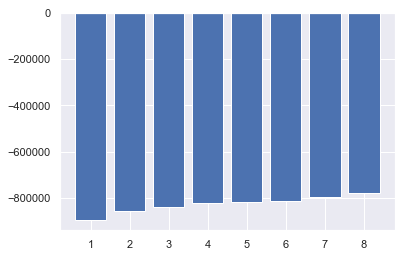

In [272]:
loglik = np.zeros_like(n_cluster, dtype=np.float64)
d = X_old.shape[1]
for k, n in enumerate(n_cluster):
    # For each feature and label find alpha and beta
    alpha = np.ones([d, n])
    beta = np.ones([d, n])
    for i, x_i in enumerate(X_old.values):
        for j, x_ij in enumerate(x_i):
            alpha[j, clusters[i,k]] += x_ij
            beta[j, clusters[i,k]] += 1 - x_ij
    # For each datapoint, find log lik
    for i, x_i in enumerate(X_old.values):
        for j, x_ij in enumerate(x_i):
            a = alpha[j, clusters[i,k]]
            b = beta[j, clusters[i,k]]
            p_jk = a / (a + b)
            loglik[k] += np.log(x_ij*p_jk + (1-x_ij)*(1-p_jk))
plt.bar(n_cluster, loglik)

<BarContainer object of 8 artists>

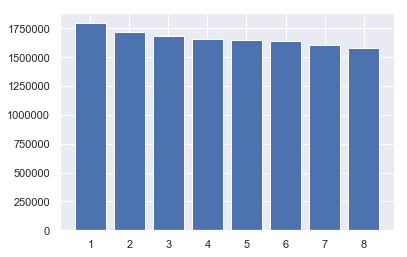

In [273]:
BIC = np.zeros_like(loglik)
for i, n in enumerate(n_cluster):
    BIC[i] = np.log(X_old.shape[0])*d*2*n - 2*loglik[i]
plt.bar(n_cluster, BIC)

In [274]:
BIC

array([1794487.73574171, 1715860.66473965, 1683694.00368645,
       1653585.91563053, 1646219.52234811, 1639873.67265937,
       1607984.27613302, 1578755.40693823])

Here every metric we use supports the maximum number of clusters, so probably we should have tested with more possible clusters to see if one of them would top out. FOr now, we'll go on with the 8.

In [275]:
n_cluster = 8

In [276]:
C = clusters[:,(n_cluster-1)]
Counter(C)

Counter({6: 2755, 2: 653, 0: 1208, 3: 665, 1: 1122, 7: 2708, 5: 451, 4: 438})

In [277]:
response_matrix = np.zeros([n_cluster,2,2])
for i in range(len(A)):
    response_matrix[C[i],A.values[i],Y.values[i]] += 1
np.round(response_matrix,decimals=0)

array([[[ 947.,    0.],
        [  85.,  176.]],

       [[ 844.,    0.],
        [ 154.,  124.]],

       [[ 427.,    2.],
        [  54.,  170.]],

       [[ 580.,    0.],
        [  57.,   28.]],

       [[ 376.,    0.],
        [  23.,   39.]],

       [[ 296.,    0.],
        [  69.,   86.]],

       [[2003.,   67.],
        [  57.,  628.]],

       [[2160.,    0.],
        [ 447.,  101.]]])

In [279]:
np.round(response_matrix/response_matrix.sum(axis=2).reshape(n_cluster,2,1),decimals=2)

array([[[1.  , 0.  ],
        [0.33, 0.67]],

       [[1.  , 0.  ],
        [0.55, 0.45]],

       [[1.  , 0.  ],
        [0.24, 0.76]],

       [[1.  , 0.  ],
        [0.67, 0.33]],

       [[1.  , 0.  ],
        [0.37, 0.63]],

       [[1.  , 0.  ],
        [0.45, 0.55]],

       [[0.97, 0.03],
        [0.08, 0.92]],

       [[1.  , 0.  ],
        [0.82, 0.18]]])

We see here a huge difference in healing rate between the two last and largest clusters. For cluster 7 the treatment is almost ineffective. Seeing how we have two clusters that show the most difference and that hold the majority of the data, so it might be interesting to see with two clusters.

In [280]:
n_cluster = 2

In [281]:
C = clusters[:,(n_cluster-1)]
Counter(C)

Counter({0: 5067, 1: 4933})

In [282]:
response_matrix = np.zeros([n_cluster,2,2])
for i in range(len(A)):
    response_matrix[C[i],A.values[i],Y.values[i]] += 1
np.round(response_matrix,decimals=0)

array([[[3673.,   69.],
        [ 265., 1060.]],

       [[3960.,    0.],
        [ 681.,  292.]]])

In [283]:
np.round(response_matrix/response_matrix.sum(axis=2).reshape(n_cluster,2,1),decimals=2)

array([[[0.98, 0.02],
        [0.2 , 0.8 ]],

       [[1.  , 0.  ],
        [0.7 , 0.3 ]]])

Here we see the differences very clearly. Everyone who is healed on placebo is in the one cluster, and the people in that cluster also have a far higher probability of being healed with the active treatment. That being said, the treatment is far better than placebo for everyone.

Trying the same again with higher number of features to get better distance calculations. With only 4 binary features used to calculate distances between points I suppose we'd be quite likely to see 16 clusters with internal distance 0, so we need to use more features to discriminate better between points.

In [284]:
B = 100
clf = ExtraTreesClassifier(n_estimators=1000)
top17 = np.zeros(len(X_A1.columns.values))
for b in range(B):
    X_S, y_S = resample(X_A1, Y_A1, n_samples=2000)
    clf.fit(X_S, y_S.values.ravel())
    top17[(np.argsort(clf.feature_importances_)[::-1])[:17]] += 1
top17 = {X_A1.columns.values[i]: v for i, v in enumerate(top17)}
sorted(top17.items(), key=lambda val: val[1])[-20:]

[('gene12', 19.0),
 ('gene26', 21.0),
 ('gene116', 25.0),
 ('gene96', 75.0),
 ('gene84', 76.0),
 ('gene124', 76.0),
 ('gene125', 77.0),
 ('gene1', 80.0),
 ('gene41', 94.0),
 ('gene57', 94.0),
 ('gene83', 96.0),
 ('gene43', 98.0),
 ('gene126', 98.0),
 ('gene23', 99.0),
 ('gene47', 99.0),
 ('gene49', 99.0),
 ('gene6', 100.0),
 ('gene22', 100.0),
 ('gene100', 100.0),
 ('gene101', 100.0)]

In [285]:
X_sub = X[['gene101', 'gene6', 'gene100', 'gene22', 'gene49', 'gene47', 'gene23', 
           'gene126', 'gene43', 'gene83', 'gene57', 'gene41']].copy()
distances3 = pairwise_distances(X_sub, metric=sokalmichener)

<BarContainer object of 7 artists>

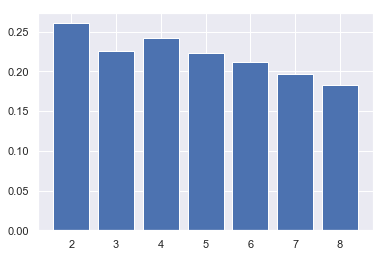

In [286]:
n_cluster = np.arange(1,9)
scores = np.zeros(len(n_cluster))
clusters = np.zeros([len(X_sub), len(n_cluster)], dtype=np.int)
for i, n in enumerate(n_cluster):
    clusterer = AgglomerativeClustering(n_clusters=n, affinity='precomputed', 
                                        linkage="average")
    clusters[:,i] = clusterer.fit_predict(distances3)
for i in range(1, len(n_cluster)):
    scores[i] = silhouette_score(distances3, clusters[:,i], metric='precomputed')
plt.bar(n_cluster[1:], scores[1:])

In [294]:
n_cluster = 2
C = clusters[:,(n_cluster-1)]
Counter(C)

Counter({0: 5066, 1: 4934})

In [295]:
response_matrix = np.zeros([n_cluster,2,2])
for i in range(len(A)):
    response_matrix[C[i],A.values[i],Y.values[i]] += 1
np.round(response_matrix,decimals=0)

array([[[3816.,   67.],
        [ 282.,  901.]],

       [[3817.,    2.],
        [ 664.,  451.]]])

In [296]:
np.round(response_matrix/response_matrix.sum(axis=2).reshape(n_cluster,2,1),decimals=2)

array([[[0.98, 0.02],
        [0.24, 0.76]],

       [[1.  , 0.  ],
        [0.6 , 0.4 ]]])

So with these predictors we get 2 clusters as the most likely model by silhouette score, but the two clusters we get are much less defined according to healing rates than the two we got using only a few predictors. It's perhaps not so strange given that those predictors are the ones most closely correlated with healing.

## Part 2 - Improved policies

### Exercise 1 - Measuring utility

We have been given the formula $U = \sum_t r_t$, but this will give larger utility for large populations. If we want to compare policies using utility it seems to me far more reasonable to use $U = \frac{1}{N}\sum_t r_t$.

In [333]:
def utility(a, y):
    return np.sum(-0.1*a + y) / len(a)

In [342]:
utility(A.values,Y.values)

0.11912

In [347]:
B = 1000
utilities = np.zeros(B)
for i in range(B):
    indices = resample(np.arange(1,len(A)))
    utilities[i] = utility(A.iloc[indices].values, Y.iloc[indices].values)

Mean: 0.119; 95%CI: [0.113,0.125]


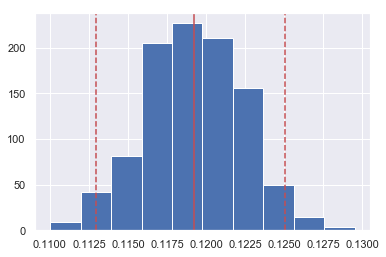

In [348]:
alpha = 0.05
lower = sorted(utilities)[round(B*alpha/2)]
mean= np.mean(utilities)
upper = sorted(utilities)[round(B*(1-alpha/2))]
plt.hist(utilities)
plt.axvline(mean, color='r', linestyle='-')
for value in (lower, upper):
    plt.axvline(value, color='r', linestyle='--')
print(f"Mean: {mean:.3f}; 95%CI: [{lower:.3f},{upper:.3f}]")

So we see the utility of $\pi_0$ on the historical data is 0.11912. By creating 1000 bootstrap samples of the historical data and calculating the utility of each we can get a mean and a confidence interval for the expected utility provided the historical data is representative of new data. Our mean her is about the same as we got on the historical data, and we get a fairly narrow confidence interval of [0.113,0.125].

### Exercise 2 - Improved policies

So how to set about creating an improved policy? In the skeleton code provided there is a fit_data method for preprocessing data unsupervised before, I presume, we are to fit the data with treatment outcome. What this initial preprocessing is to do I am a little uncertain about. In part 1 we attempted some clustering, but the overall impression from that was that the clusters were terribly poorly definesd unless you reduced the feature space to such an extent that a lot of the data points simply wound up in the same point. In addition we don't know anything about what the clusters would imply for our policy.  

We could of course create different models for each cluster, hoping that will give us some improvement on prediction, but in reality I think that would just restrict our classificator based on some constraint that is heavily influenced by randomness.

In [357]:
X_data = X_old.copy()
X_data = X_data.rename(index=str, columns={128: 'symptom1', 129: 'symptom2'})

Let's try Logistic Regression on $A=1$ to build a model predicting who will get better given a treatment, and then another on $A=0$ to build a model predicting who will get better without treatment, and then we can calculate for new data points the probability of getting better given each possible action, giving us a basis for deciding which action maximizes the reward.

In [359]:
from sklearn.preprocessing import StandardScaler

In [360]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X_data)

In [418]:
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.metrics import accuracy_score

In [461]:
X_A1 = X_sc[(A==1).values[:,0],:]
Y_A1 = Y.iloc[(A==1).values[:,0],].values.ravel()
n_repeats = 10
n_folds = 10
Cs = np.logspace(0,4,20)
accuracies = np.zeros(len(Cs))
deviations = np.zeros(len(Cs))
for i, c in enumerate(Cs):
    print(f"C={c:.3f}")
    accuracy = np.zeros(n_repeats * n_folds)
    j = 0
    for _ in range(n_repeats):
        for train, test in KFold(n_splits=n_folds).split(X_A1):
            Xtr, ytr = (X_A1[train,], Y_A1[train])
            Xte, yte = (X_A1[test,], Y_A1[test])
            y_pred = LogisticRegression(C=c).fit(Xtr, ytr).predict(Xte)
            accuracy[j] = accuracy_score(y_pred, yte)
            j += 1
    accuracies[i] = np.mean(accuracy)
    deviations[i] = stats.sem(accuracy)

C=1.000
C=1.624
C=2.637
C=4.281
C=6.952
C=11.288
C=18.330
C=29.764
C=48.329
C=78.476
C=127.427
C=206.914
C=335.982
C=545.559
C=885.867
C=1438.450
C=2335.721
C=3792.690
C=6158.482
C=10000.000


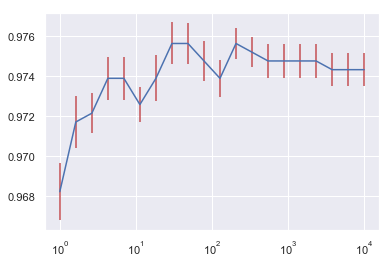

In [462]:
plt.errorbar(Cs, accuracies, yerr=deviations, ecolor='r')
plt.xscale('log')

So we see here clearly that the Logistic Regression predicts better than any clustering we have attempted, even when selecting features to be used for clustering based on the outcome, and the clustering algorithm used doesn't support clustering of new data without refitting the entire dataset. Other clustering algorithms supporting this often are making assumption about the data that don't hold in our case.  
We also see that there is little risk of overfitting and no need to regularize almost at all. At close to 98% accuracy there might not be much point in trying other classifiers eiethr, though it looks like a more flexible model might be appropriate.

Let's try to see how we do with the people who didn't get treated. Can we predict their healing? Here the healing rate is no longer about 50/50 as above, but close to 0, so the stupid predictor $Y_t=0 \forall t$ has a close to 1 accuracy. We therefore need to measure something else. A combination of sensitivity and precision perhaps?

In [497]:
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import RepeatedStratifiedKFold

In [496]:
X_A1 = X_sc[(A==0).values[:,0],:]
Y_A1 = Y.iloc[(A==0).values[:,0],].values.ravel()
n_repeats = 5
n_folds = 10
Cs = np.logspace(-3,3,20)
accuracies = np.zeros(len(Cs))
deviations = np.zeros(len(Cs))
for i, c in enumerate(Cs):
    print(f"C={c:.3f}")
    accuracy = np.zeros(n_folds * n_repeats)
    j = 0
    rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats)
    for train, test in rskf.split(X_A1, Y_A1):
        Xtr, ytr = (X_A1[train,], Y_A1[train])
        Xte, yte = (X_A1[test,], Y_A1[test])
        y_pred = LogisticRegression(C=c).fit(Xtr, ytr).predict(Xte)
        accuracy[j] = matthews_corrcoef(y_pred, yte)
        j += 1
    accuracies[i] = np.mean(accuracy)
    deviations[i] = stats.sem(accuracy)

C=0.001


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C=0.002
C=0.004
C=0.009
C=0.018
C=0.038
C=0.078
C=0.162
C=0.336
C=0.695
C=1.438
C=2.976
C=6.158
C=12.743
C=26.367
C=54.556
C=112.884
C=233.572
C=483.293
C=1000.000


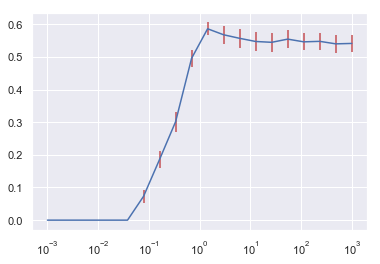

In [498]:
plt.errorbar(Cs, accuracies, yerr=deviations, ecolor='r')
plt.xscale('log')

In [492]:
accuracies

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.63439394, 0.59217172, 0.579136  , 0.56177489, 0.55677489,
       0.56670455, 0.55866883, 0.56102994, 0.55380772, 0.55556097])

This was using l2-penalty, which in general gives better prediction, but that has a wekaness compared to l1-penalty for high dimensional data with few true predictors. From our previous analysis it appears that there are in fact only a few truly influential predictors, so l1-penalty might be more appropriate and give better results, though given the amount of data and the quality of the predictions of the almost unregularized l2-regression I don't suppose it's very likely.

0
C=0.010
C=0.018
C=0.034
C=0.062
C=0.113
C=0.207
C=0.379
C=0.695
C=1.274
C=2.336
C=4.281
C=7.848
C=14.384
C=26.367
C=48.329
C=88.587
C=162.378
C=297.635
C=545.559
C=1000.000


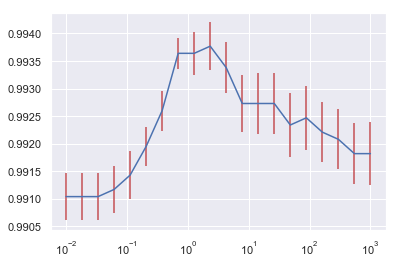

1
C=1.000
C=1.438
C=2.069
C=2.976
C=4.281
C=6.158
C=8.859
C=12.743
C=18.330
C=26.367
C=37.927
C=54.556
C=78.476
C=112.884
C=162.378
C=233.572
C=335.982
C=483.293
C=695.193
C=1000.000


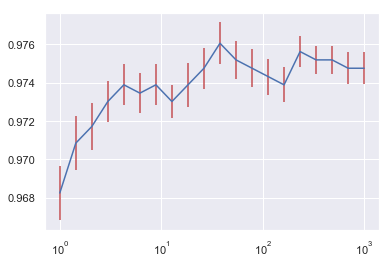

In [468]:
n_repeats = 5
n_folds = 10
Cs = [np.logspace(-2,3,20), np.logspace(0,3,20)]
measure = (accuracy_score, )
for a in (0,1):
    print(a)
    X_A1 = X_sc[(A==a).values[:,0],:]
    Y_A1 = Y.iloc[(A==a).values[:,0],].values.ravel()
    accuracies = np.zeros(len(Cs[a]))
    deviations = np.zeros(len(Cs[a]))
    for i, c in enumerate(Cs[a]):
        print(f"C={c:.3f}")
        accuracy = np.zeros(n_folds * n_repeats)
        j = 0
        for _ in range(n_repeats):
            for train, test in KFold(n_splits=n_folds).split(X_A1):
                Xtr, ytr = (X_A1[train,], Y_A1[train])
                Xte, yte = (X_A1[test,], Y_A1[test])
                y_pred = LogisticRegression(C=c).fit(Xtr, ytr).predict(Xte)
                accuracy[j] = accuracy_score(y_pred, yte)
                j += 1
        accuracies[i] = np.mean(accuracy)
        deviations[i] = stats.sem(accuracy)
    plt.errorbar(Cs[a], accuracies, yerr=deviations, ecolor='r')
    plt.xscale('log')
    plt.show()

So the picture is much the same for both penalties. Same accuracy and same optimal $\lambda$. But what if we had less data? Would this hold also then?